In [1]:
import pandas as pd

In [2]:
import numpy as np

In [36]:
df_user_log=pd.read_csv('https://drive.google.com/uc?id=1DwEvKOYl0hQmd2muwDa13O17smPPgn0D')

In [34]:
df_user_info=pd.read_csv('https://drive.google.com/uc?id=1wM9LY4rAsMLGe6GUZNQd50R8WHiH9xaf')

In [37]:
df_user_log

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,269460,481,1331,318,4275,1007,3
1,217993,481,1331,318,4275,1103,0
2,56706,481,1331,318,4275,1023,0
3,129441,482,1656,1274,5235,523,0
4,203651,483,351,840,2668,1022,0
...,...,...,...,...,...,...,...
164,34584,628,737,1234,2103,527,0
165,378893,628,737,1234,2103,607,0
166,26271,628,737,1234,2103,527,0
167,66609,638,812,4547,623,1111,0


In [5]:
df_user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,230630.059172,551.431953,880.325444,1943.307692,2570.017751,868.727811,0.414201
std,120077.171840,46.083224,434.790502,1368.447378,2103.158476,223.326734,0.935433
min,445.000000,481.000000,115.000000,71.000000,394.000000,516.000000,0.000000
25%,131526.000000,517.000000,662.000000,862.000000,1345.000000,626.000000,0.000000
50%,257183.000000,548.000000,737.000000,1653.000000,1954.000000,916.000000,0.000000
75%,326302.000000,575.000000,1255.000000,2792.000000,3467.000000,1107.000000,0.000000
max,422987.000000,640.000000,1656.000000,4966.000000,8281.000000,1111.000000,3.000000


In [38]:
df_user_log.isnull().any()

user_id        False
item_id        False
cat_id         False
seller_id      False
brand_id       False
time_stamp     False
action_type    False
dtype: bool

In [7]:
import seaborn as sns

<Axes: xlabel='action_type', ylabel='count'>

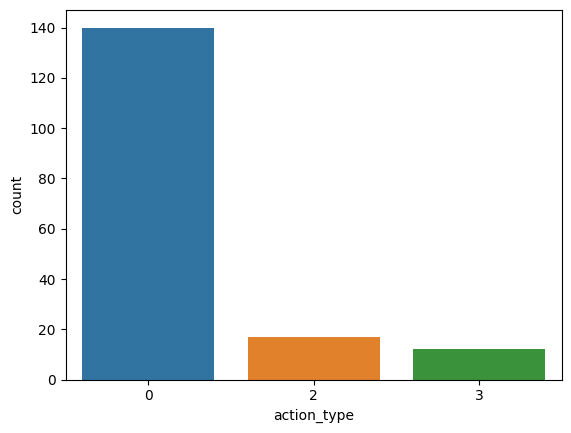

In [39]:
sns.countplot(x='action_type', data=df_user_log)

In [43]:
df_user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,269460,481,1331,318,4275,1007,3
1,217993,481,1331,318,4275,1103,0
2,56706,481,1331,318,4275,1023,0
3,129441,482,1656,1274,5235,523,0
4,203651,483,351,840,2668,1022,0


In [44]:
df_user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [45]:
merged_df = pd.merge(df_user_log, df_user_info, on='user_id')

<Axes: xlabel='gender', ylabel='count'>

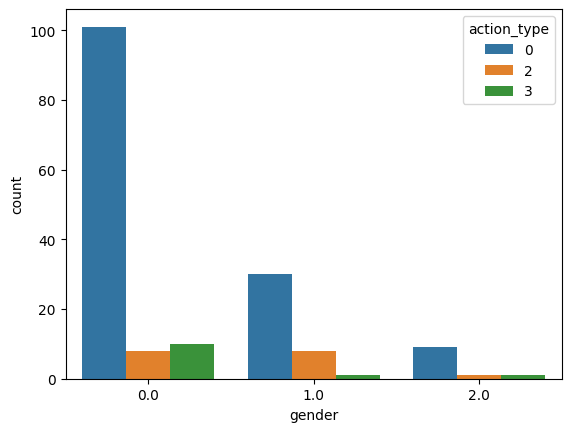

In [46]:
import seaborn as sns

sns.countplot(x='gender', hue='action_type', data=merged_df)

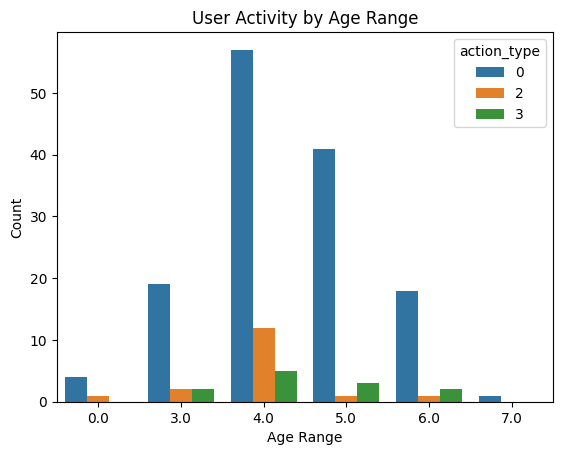

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a countplot of user activity by age range
sns.countplot(x='age_range', hue='action_type', data=merged_df)
plt.title('User Activity by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')

plt.show()


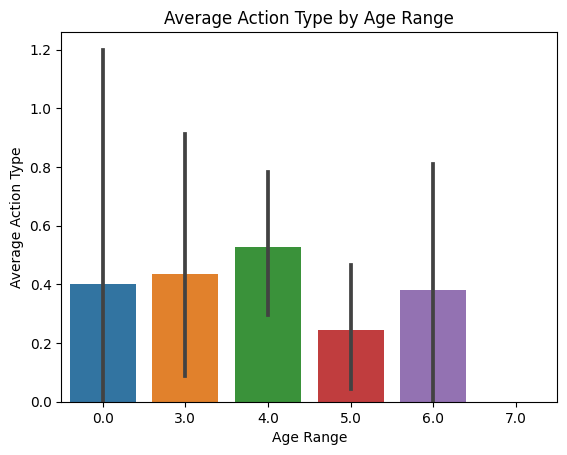

In [50]:
# create a barplot of average action type by age range
sns.barplot(x='age_range', y='action_type', data=merged_df)
plt.title('Average Action Type by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Average Action Type')
plt.show()

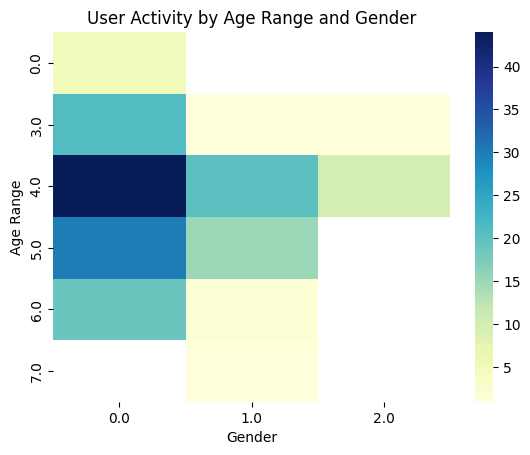

In [51]:
# create a heatmap of user activity by age range and gender
heatmap_df = merged_df.pivot_table(index='age_range', columns='gender', values='action_type', aggfunc='count')
sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('User Activity by Age Range and Gender')
plt.xlabel('Gender')
plt.ylabel('Age Range')

plt.show()